We’ll start by doing all necessary imports, and we’ll let our Jupyter Notebook know that it should display graphs and images in the notebook itself.

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import urllib
import sys
import os
import zipfile
tf.__version__

'1.10.0'

The files we're about to use may take five minutes or more to download, so if you're following along by running the program in the corresponding notebook, feel free to start running the next few cells. In the meantime, let’s explore textual entailment in further detail.

In [2]:
glove_zip_file = "glove.6B.zip"
glove_vectors_file = "glove.6B.50d.txt"

snli_zip_file = "snli_1.0.zip"
snli_dev_file = "snli_1.0_dev.txt"
snli_full_dataset_file = "snli_1.0_train.txt"

In [3]:
from six.moves.urllib.request import urlretrieve
    
#large file - 862 MB
if (not os.path.isfile(glove_zip_file) and
    not os.path.isfile(glove_vectors_file)):
    urlretrieve ("http://nlp.stanford.edu/data/glove.6B.zip", 
                 glove_zip_file)

#medium-sized file - 94.6 MB
if (not os.path.isfile(snli_zip_file) and
    not os.path.isfile(snli_dev_file)):
    urlretrieve ("https://nlp.stanford.edu/projects/snli/snli_1.0.zip", 
                 snli_zip_file)

In [4]:
def unzip_single_file(zip_file_name, output_file_name):
    """
        If the outFile is already created, don't recreate
        If the outFile does not exist, create it from the zipFile
    """
    if not os.path.isfile(output_file_name):
        with open(output_file_name, 'wb') as out_file:
            with zipfile.ZipFile(zip_file_name) as zipped:
                for info in zipped.infolist():
                    if output_file_name in info.filename:
                        with zipped.open(info) as requested_file:
                            out_file.write(requested_file.read())
                            return

unzip_single_file(glove_zip_file, glove_vectors_file)
unzip_single_file(snli_zip_file, snli_dev_file)
# unzip_single_file(snli_zip_file, snli_full_dataset_file)

---

Now that we have our GloVe vectors downloaded, we can load them into memory, deserializing the space separated format into a Python dictionary:

In [5]:
glove_wordmap = {}
with open(glove_vectors_file, "r",encoding='utf-8') as glove:
    for line in glove:
        name, vector = tuple(line.split(" ", 1))
        glove_wordmap[name] = np.fromstring(vector, sep=" ")

---

Once we have our words, we need our input to contain entire sentences and process it through a neural network. Let's start with making the sequence:

In [6]:
def sentence2sequence(sentence):
    """
     
    - Turns an input sentence into an (n,d) matrix, 
        where n is the number of tokens in the sentence
        and d is the number of dimensions each word vector has.
    
      Tensorflow doesn't need to be used here, as simply
      turning the sentence into a sequence based off our 
      mapping does not need the computational power that
      Tensorflow provides. Normal Python suffices for this task.
    """
    tokens = sentence.lower().split(" ")
    rows = []
    words = []
    #Greedy search for tokens
    for token in tokens:
        i = len(token)
        while len(token) > 0 and i > 0:
            word = token[:i]
            if word in glove_wordmap:
                rows.append(glove_wordmap[word])
                words.append(word)
                token = token[i:]
                i = len(token)
            else:
                i = i-1
    return rows, words

To better visualize the word vectorization process, and to see what the computer sees when it looks at a sentence, we can represent the vectors as images. Each row represents a single word, and the columns represent individual dimensions of the vectorized word.  The vectorizations are trained in terms of relationships to other words, and so what the representations actually mean is ambiguous.  The computer can understand this vector language, and that’s the most important part to us. Generally speaking, two vectors that contain similar colors in the same positions represent words that are similar in meaning.


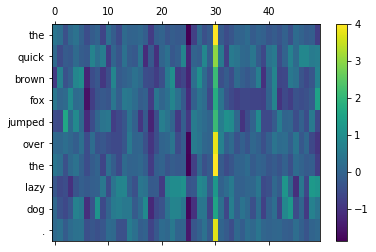

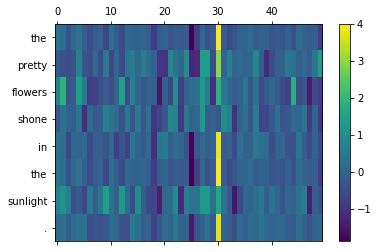

In [7]:
def visualize(sentence):
    rows, words = sentence2sequence(sentence)
    mat = np.vstack(rows)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    shown = ax.matshow(mat, aspect="auto")
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.colorbar(shown)
    
    ax.set_yticklabels([""]+words)
    plt.show()
    
visualize("The quick brown fox jumped over the lazy dog.")
visualize("The pretty flowers shone in the sunlight.")

-----
Recurrent Neural Networks (also known as RNNs) are a sequence-learning tool for neural networks. This type of neural network has only one layer’s worth of hidden inputs, which is re-used for each input from the sequence, along with a “memory” that’s passed ahead to the next input’s calculations. These are calculated using matrix multiplication where the matrix indices are trained weights, just like they are in a fully-connected layer. 

The same calculations are repeated for each input in the sequence, meaning that a single “layer” of a recurrent neural network can be unrolled into many layers. In fact, there will be as many layers as there are inputs in the sequence. This allows the network to process a very complex sentence. TensorFlow includes its own implementation of a vanilla RNN cell, BasicRNNCell, which can be added to your TensorFlow graph as follows:

In [8]:
rnn_size = 64
rnn = tf.contrib.rnn.BasicRNNCell(rnn_size)

----

# Defining the constants for our network

Since we aren’t going to use a vanilla RNN layer in our network, let's clear out the graph and add an LSTM layer, which TensorFlow also includes by default. Since this is going to be the first part of our actual network, let's also define all the constants we'll need for the network, which we'll talk about as they come up:

In [9]:
#Constants setup
max_hypothesis_length, max_evidence_length = 30, 30
batch_size, vector_size, hidden_size = 128, 50, 64

lstm_size = hidden_size

weight_decay = 0.0001

learning_rate = 1

input_p, output_p = 0.5, 0.5

training_iterations_count = 100000

display_step = 10

def score_setup(row):
    convert_dict = {
      'entailment': 0,
      'neutral': 1,
      'contradiction': 2
    }
    score = np.zeros((3,))
    for x in range(1,6):
        tag = row["label"+str(x)]
        if tag in convert_dict: score[convert_dict[tag]] += 1
    return score / (1.0*np.sum(score))

def fit_to_size(matrix, shape):
    res = np.zeros(shape)
    slices = [slice(0,min(dim,shape[e])) for e, dim in enumerate(matrix.shape)]
    res[slices] = matrix[slices]
    return res


In [10]:
def split_data_into_scores():
    import csv
    with open("snli_1.0_dev.txt","r") as data:
        train = csv.DictReader(data, delimiter='\t')
        evi_sentences = []
        hyp_sentences = []
        labels = []
        scores = []
        for row in train:
            hyp_sentences.append(np.vstack(
                    sentence2sequence(row["sentence1"].lower())[0]))
            evi_sentences.append(np.vstack(
                    sentence2sequence(row["sentence2"].lower())[0]))
            labels.append(row["gold_label"])
            scores.append(score_setup(row))
        
        hyp_sentences = np.stack([fit_to_size(x, (max_hypothesis_length, vector_size))
                          for x in hyp_sentences])
        evi_sentences = np.stack([fit_to_size(x, (max_evidence_length, vector_size))
                          for x in evi_sentences])
                                 
        return (hyp_sentences, evi_sentences), labels, np.array(scores)
    
data_feature_list, correct_values, correct_scores = split_data_into_scores()

l_h, l_e = max_hypothesis_length, max_evidence_length
N, D, H = batch_size, vector_size, hidden_size
l_seq = l_h + l_e


D:\python\Anaconda\Anaconda3\envs\ai\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


We'll also reset the graph to not include the RNN cell we added earlier, since we won't be using that for this network:



In [11]:
tf.reset_default_graph()

With both those out of the way, we can define our LSTM using TensorFlow as follows:

In [12]:
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

The loss of certain pieces of crucial memory means that complicated relationships required for first order logic have a harder time forming with dropout, and so for our LSTM layer we’ll skip using dropout on internal gates, instead using it on everything else. Thankfully, this is the default implementation of Tensorflow’s DropoutWrapper for recurrent layers:


In [13]:
lstm_drop =  tf.contrib.rnn.DropoutWrapper(lstm, input_p, output_p)

----

With all the explanations out of the way, we can finish up our model. The first step is tokenizing and using our GloVe dictionary to turn the two input sentences into a single sequence of vectors. Since we can’t effectively use dropout on information that gets passed within an LSTM, we’ll use dropout on features from words, and on final output instead -- effectively using dropout on the first and last layers from the unrolled LSTM network portions. 

The final output from the LSTMs will be passed into a set of fully connected layers, and then from that we’ll get a single real-valued score that indicates how strong each of the kinds of entailment are, which we use to select our final result and our confidence in that result.

In [14]:
# N: The number of elements in each of our batches, 
#   which we use to train subsets of data for efficiency's sake.
# l_h: The maximum length of a hypothesis, or the second sentence.  This is
#   used because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# l_e: The maximum length of evidence, the first sentence.  This is used
#   because training an RNN is extraordinarily difficult without 
#   rolling it out to a fixed length.
# D: The size of our used GloVe or other vectors.
hyp = tf.placeholder(tf.float32, [N, l_h, D], 'hypothesis')
evi = tf.placeholder(tf.float32, [N, l_e, D], 'evidence')
y = tf.placeholder(tf.float32, [N, 3], 'label')
# hyp: Where the hypotheses will be stored during training.
# evi: Where the evidences will be stored during training.
# y: Where correct scores will be stored during training.

# lstm_size: the size of the gates in the LSTM, 
#    as in the first LSTM layer's initialization.
lstm_back = tf.contrib.rnn.BasicLSTMCell(lstm_size)
# lstm_back:  The LSTM used for looking backwards 
#   through the sentences, similar to lstm.

# input_p: the probability that inputs to the LSTM will be retained at each
#   iteration of dropout.
# output_p: the probability that outputs from the LSTM will be retained at 
#   each iteration of dropout.
lstm_drop_back = tf.contrib.rnn.DropoutWrapper(lstm_back, input_p, output_p)
# lstm_drop_back:  A dropout wrapper for lstm_back, like lstm_drop.


fc_initializer = tf.random_normal_initializer(stddev=0.1) 
# fc_initializer: initial values for the fully connected layer's weights.
# hidden_size: the size of the outputs from each lstm layer.  
#   Multiplied by 2 to account for the two LSTMs.
fc_weight = tf.get_variable('fc_weight', [2*hidden_size, 3], 
                            initializer = fc_initializer)
# fc_weight: Storage for the fully connected layer's weights.
fc_bias = tf.get_variable('bias', [3])
# fc_bias: Storage for the fully connected layer's bias.

# tf.GraphKeys.REGULARIZATION_LOSSES:  A key to a collection in the graph
#   designated for losses due to regularization.
#   In this case, this portion of loss is regularization on the weights
#   for the fully connected layer.
tf.add_to_collection(tf.GraphKeys.REGULARIZATION_LOSSES, 
                     tf.nn.l2_loss(fc_weight)) 

x = tf.concat([hyp, evi], 1) # N, (Lh+Le), d
# Permuting batch_size and n_steps
x = tf.transpose(x, [1, 0, 2]) # (Le+Lh), N, d
# Reshaping to (n_steps*batch_size, n_input)
x = tf.reshape(x, [-1, vector_size]) # (Le+Lh)*N, d
# Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
x = tf.split(x, l_seq,)

# x: the inputs to the bidirectional_rnn


# tf.contrib.rnn.static_bidirectional_rnn: Runs the input through
#   two recurrent networks, one that runs the inputs forward and one
#   that runs the inputs in reversed order, combining the outputs.
rnn_outputs, _, _ = tf.contrib.rnn.static_bidirectional_rnn(lstm, lstm_back,
                                                            x, dtype=tf.float32)
# rnn_outputs: the list of LSTM outputs, as a list. 
#   What we want is the latest output, rnn_outputs[-1]

classification_scores = tf.matmul(rnn_outputs[-1], fc_weight) + fc_bias
# The scores are relative certainties for how likely the output matches
#   a certain entailment: 
#     0: Positive entailment
#     1: Neutral entailment
#     2: Negative entailment

In order to test the accuracy and begin to add in optimization constraints, we need to show TensorFlow how to calculate the accuracy, or -- the percentage of correctly predicted labels.

We also need to determine a loss, to show how poorly the network is doing. Since we have both classification scores and optimal scores, the choice here is using a variation on softmax loss from Tensorflow: tf.nn.softmax_cross_entropy_with_logits. We add in regularization losses to help with overfitting, and then prepare an optimizer to learn how to reduce the loss.

In [15]:
with tf.variable_scope('Accuracy'):
    predicts = tf.cast(tf.argmax(classification_scores, 1), 'int32')
    y_label = tf.cast(tf.argmax(y, 1), 'int32')
    corrects = tf.equal(predicts, y_label)
    num_corrects = tf.reduce_sum(tf.cast(corrects, tf.float32))
    accuracy = tf.reduce_mean(tf.cast(corrects, tf.float32))

with tf.variable_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
        logits = classification_scores, labels = y)
    loss = tf.reduce_mean(cross_entropy)
    total_loss = loss + weight_decay * tf.add_n(
        tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

optimizer = tf.train.GradientDescentOptimizer(learning_rate)

opt_op = optimizer.minimize(total_loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



Finally, we can train the network! If you installed TQDM, you can use it to keep track of progress as the network trains.


In [16]:
# Initialize variables
init = tf.global_variables_initializer()

# Use TQDM if installed
tqdm_installed = False
try:
    from tqdm import tqdm
    tqdm_installed = True
except:
    pass

# Launch the Tensorflow session
sess = tf.Session()
sess.run(init)

# training_iterations_count: The number of data pieces to train on in total
# batch_size: The number of data pieces per batch
training_iterations = range(0,training_iterations_count,batch_size)
if tqdm_installed:
    # Add a progress bar if TQDM is installed
    training_iterations = tqdm(training_iterations)

for i in training_iterations:

    # Select indices for a random data subset
    batch = np.random.randint(data_feature_list[0].shape[0], size=batch_size)
    
    # Use the selected subset indices to initialize the graph's 
    #   placeholder values
    hyps, evis, ys = (data_feature_list[0][batch,:],
                      data_feature_list[1][batch,:],
                      correct_scores[batch])
    
    # Run the optimization with these initialized values
    sess.run([opt_op], feed_dict={hyp: hyps, evi: evis, y: ys})
    # display_step: how often the accuracy and loss should 
    #   be tested and displayed.
    if (i/batch_size) % display_step == 0:
        # Calculate batch accuracy
        acc = sess.run(accuracy, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Calculate batch loss
        tmp_loss = sess.run(loss, feed_dict={hyp: hyps, evi: evis, y: ys})
        # Display results
        print("Iter " + str(i/batch_size) + ", Minibatch Loss= " + \
              "{:.6f}".format(tmp_loss) + ", Training Accuracy= " + \
              "{:.5f}".format(acc))

  0%|                                                                                          | 0/782 [00:00<?, ?it/s]

Iter 0.0, Minibatch Loss= 1.118536, Training Accuracy= 0.28906


  1%|█                                                                                | 10/782 [00:04<08:37,  1.49it/s]

Iter 10.0, Minibatch Loss= 1.096389, Training Accuracy= 0.36719


  2%|█▉                                                                               | 19/782 [00:05<02:27,  5.18it/s]

Iter 20.0, Minibatch Loss= 1.096107, Training Accuracy= 0.39844


  4%|███                                                                              | 30/782 [00:06<01:23,  9.00it/s]

Iter 30.0, Minibatch Loss= 1.093882, Training Accuracy= 0.36719


  5%|████▏                                                                            | 40/782 [00:07<01:19,  9.37it/s]

Iter 40.0, Minibatch Loss= 1.095443, Training Accuracy= 0.40625


  6%|█████                                                                            | 49/782 [00:08<01:19,  9.26it/s]

Iter 50.0, Minibatch Loss= 1.089208, Training Accuracy= 0.34375


  8%|██████▏                                                                          | 60/782 [00:09<01:13,  9.87it/s]

Iter 60.0, Minibatch Loss= 1.086882, Training Accuracy= 0.37500


  9%|███████▎                                                                         | 70/782 [00:10<01:21,  8.79it/s]

Iter 70.0, Minibatch Loss= 1.094169, Training Accuracy= 0.36719


 10%|████████▎                                                                        | 80/782 [00:11<01:11,  9.88it/s]

Iter 80.0, Minibatch Loss= 1.089452, Training Accuracy= 0.44531


 12%|█████████▎                                                                       | 90/782 [00:12<01:07, 10.30it/s]

Iter 90.0, Minibatch Loss= 1.084928, Training Accuracy= 0.40625


 13%|██████████▏                                                                     | 100/782 [00:13<01:04, 10.55it/s]

Iter 100.0, Minibatch Loss= 1.081334, Training Accuracy= 0.43750


 14%|███████████▎                                                                    | 110/782 [00:14<01:03, 10.62it/s]

Iter 110.0, Minibatch Loss= 1.092254, Training Accuracy= 0.43750


 15%|████████████▎                                                                   | 120/782 [00:15<01:01, 10.75it/s]

Iter 120.0, Minibatch Loss= 1.079390, Training Accuracy= 0.41406


 17%|█████████████▎                                                                  | 130/782 [00:16<01:01, 10.64it/s]

Iter 130.0, Minibatch Loss= 1.071311, Training Accuracy= 0.46094


 18%|██████████████▎                                                                 | 140/782 [00:17<01:01, 10.46it/s]

Iter 140.0, Minibatch Loss= 1.083192, Training Accuracy= 0.43750


 19%|███████████████▎                                                                | 150/782 [00:18<00:58, 10.72it/s]

Iter 150.0, Minibatch Loss= 1.117624, Training Accuracy= 0.35156


 20%|████████████████▎                                                               | 160/782 [00:19<00:58, 10.71it/s]

Iter 160.0, Minibatch Loss= 1.065190, Training Accuracy= 0.43750


 22%|█████████████████▍                                                              | 170/782 [00:20<00:58, 10.54it/s]

Iter 170.0, Minibatch Loss= 1.072210, Training Accuracy= 0.42969


 23%|██████████████████▍                                                             | 180/782 [00:21<00:55, 10.78it/s]

Iter 180.0, Minibatch Loss= 1.071893, Training Accuracy= 0.44531


 24%|███████████████████▍                                                            | 190/782 [00:22<01:03,  9.32it/s]

Iter 190.0, Minibatch Loss= 1.135234, Training Accuracy= 0.36719


 25%|████████████████████▎                                                           | 199/782 [00:23<01:02,  9.31it/s]

Iter 200.0, Minibatch Loss= 1.024009, Training Accuracy= 0.48438


 27%|█████████████████████▍                                                          | 209/782 [00:24<00:56, 10.09it/s]

Iter 210.0, Minibatch Loss= 1.061342, Training Accuracy= 0.42969


 28%|██████████████████████▍                                                         | 219/782 [00:25<00:57,  9.74it/s]

Iter 220.0, Minibatch Loss= 1.097655, Training Accuracy= 0.37500


 29%|███████████████████████▍                                                        | 229/782 [00:26<00:54, 10.20it/s]

Iter 230.0, Minibatch Loss= 1.044123, Training Accuracy= 0.46875


 31%|████████████████████████▍                                                       | 239/782 [00:27<00:52, 10.36it/s]

Iter 240.0, Minibatch Loss= 1.062919, Training Accuracy= 0.47656


 32%|█████████████████████████▍                                                      | 249/782 [00:28<00:49, 10.75it/s]

Iter 250.0, Minibatch Loss= 1.061171, Training Accuracy= 0.49219


 33%|██████████████████████████▍                                                     | 259/782 [00:29<00:49, 10.51it/s]

Iter 260.0, Minibatch Loss= 1.083997, Training Accuracy= 0.34375


 34%|███████████████████████████▌                                                    | 269/782 [00:30<00:50, 10.11it/s]

Iter 270.0, Minibatch Loss= 1.051381, Training Accuracy= 0.43750


 36%|████████████████████████████▌                                                   | 279/782 [00:31<00:47, 10.61it/s]

Iter 280.0, Minibatch Loss= 1.080583, Training Accuracy= 0.39844


 37%|█████████████████████████████▌                                                  | 289/782 [00:32<00:47, 10.38it/s]

Iter 290.0, Minibatch Loss= 1.067659, Training Accuracy= 0.38281


 38%|██████████████████████████████▌                                                 | 299/782 [00:33<00:44, 10.84it/s]

Iter 300.0, Minibatch Loss= 1.058174, Training Accuracy= 0.47656


 40%|███████████████████████████████▌                                                | 309/782 [00:34<00:45, 10.51it/s]

Iter 310.0, Minibatch Loss= 1.052339, Training Accuracy= 0.45312


 41%|████████████████████████████████▋                                               | 319/782 [00:35<00:44, 10.34it/s]

Iter 320.0, Minibatch Loss= 1.034779, Training Accuracy= 0.46094


 42%|█████████████████████████████████▊                                              | 330/782 [00:37<00:43, 10.29it/s]

Iter 330.0, Minibatch Loss= 1.066531, Training Accuracy= 0.44531


 43%|██████████████████████████████████▊                                             | 340/782 [00:38<00:47,  9.23it/s]

Iter 340.0, Minibatch Loss= 1.019616, Training Accuracy= 0.50000


 45%|███████████████████████████████████▊                                            | 350/782 [00:39<00:47,  9.14it/s]

Iter 350.0, Minibatch Loss= 1.048531, Training Accuracy= 0.42969


 46%|████████████████████████████████████▊                                           | 360/782 [00:40<00:48,  8.63it/s]

Iter 360.0, Minibatch Loss= 1.076660, Training Accuracy= 0.44531


 47%|█████████████████████████████████████▊                                          | 370/782 [00:41<00:46,  8.77it/s]

Iter 370.0, Minibatch Loss= 1.071152, Training Accuracy= 0.41406


 48%|██████████████████████████████████████▊                                         | 379/782 [00:42<00:43,  9.37it/s]

Iter 380.0, Minibatch Loss= 1.082351, Training Accuracy= 0.39844


 50%|███████████████████████████████████████▊                                        | 389/782 [00:43<00:39,  9.94it/s]

Iter 390.0, Minibatch Loss= 1.044724, Training Accuracy= 0.44531


 51%|████████████████████████████████████████▉                                       | 400/782 [00:45<00:38,  9.84it/s]

Iter 400.0, Minibatch Loss= 1.078775, Training Accuracy= 0.42188


 52%|█████████████████████████████████████████▊                                      | 409/782 [00:46<00:39,  9.33it/s]

Iter 410.0, Minibatch Loss= 1.040064, Training Accuracy= 0.41406


 54%|██████████████████████████████████████████▉                                     | 420/782 [00:47<00:36,  9.92it/s]

Iter 420.0, Minibatch Loss= 1.039510, Training Accuracy= 0.50000


 55%|███████████████████████████████████████████▉                                    | 430/782 [00:48<00:35,  9.78it/s]

Iter 430.0, Minibatch Loss= 1.045885, Training Accuracy= 0.48438


 56%|█████████████████████████████████████████████                                   | 440/782 [00:49<00:36,  9.34it/s]

Iter 440.0, Minibatch Loss= 1.040119, Training Accuracy= 0.51562


 57%|█████████████████████████████████████████████▉                                  | 449/782 [00:50<00:32, 10.10it/s]

Iter 450.0, Minibatch Loss= 1.023555, Training Accuracy= 0.45312


 59%|██████████████████████████████████████████████▉                                 | 459/782 [00:51<00:32,  9.90it/s]

Iter 460.0, Minibatch Loss= 1.015333, Training Accuracy= 0.51562


 60%|████████████████████████████████████████████████                                | 470/782 [00:52<00:32,  9.55it/s]

Iter 470.0, Minibatch Loss= 1.035656, Training Accuracy= 0.49219


 61%|█████████████████████████████████████████████████                               | 480/782 [00:53<00:32,  9.37it/s]

Iter 480.0, Minibatch Loss= 1.023404, Training Accuracy= 0.45312


 63%|██████████████████████████████████████████████████▏                             | 490/782 [00:55<00:34,  8.39it/s]

Iter 490.0, Minibatch Loss= 1.055301, Training Accuracy= 0.48438


 64%|███████████████████████████████████████████████████▏                            | 500/782 [00:56<00:36,  7.67it/s]

Iter 500.0, Minibatch Loss= 1.030598, Training Accuracy= 0.52344


 65%|████████████████████████████████████████████████████                            | 509/782 [00:57<00:33,  8.27it/s]

Iter 510.0, Minibatch Loss= 1.047566, Training Accuracy= 0.50781


 66%|█████████████████████████████████████████████████████▏                          | 520/782 [00:58<00:26,  9.90it/s]

Iter 520.0, Minibatch Loss= 1.066983, Training Accuracy= 0.40625


 68%|██████████████████████████████████████████████████████                          | 529/782 [00:59<00:27,  9.21it/s]

Iter 530.0, Minibatch Loss= 1.005916, Training Accuracy= 0.54688


 69%|███████████████████████████████████████████████████████▏                        | 539/782 [01:00<00:24,  9.90it/s]

Iter 540.0, Minibatch Loss= 1.012603, Training Accuracy= 0.56250


 70%|████████████████████████████████████████████████████████▏                       | 549/782 [01:01<00:25,  9.17it/s]

Iter 550.0, Minibatch Loss= 1.082921, Training Accuracy= 0.36719


 72%|█████████████████████████████████████████████████████████▎                      | 560/782 [01:03<00:25,  8.61it/s]

Iter 560.0, Minibatch Loss= 1.034526, Training Accuracy= 0.47656


 73%|██████████████████████████████████████████████████████████▏                     | 569/782 [01:04<00:22,  9.53it/s]

Iter 570.0, Minibatch Loss= 1.053771, Training Accuracy= 0.52344


 74%|███████████████████████████████████████████████████████████▎                    | 580/782 [01:05<00:21,  9.36it/s]

Iter 580.0, Minibatch Loss= 1.004995, Training Accuracy= 0.51562


 75%|████████████████████████████████████████████████████████████▎                   | 589/782 [01:06<00:20,  9.58it/s]

Iter 590.0, Minibatch Loss= 1.039814, Training Accuracy= 0.51562


 77%|█████████████████████████████████████████████████████████████▎                  | 599/782 [01:07<00:17, 10.41it/s]

Iter 600.0, Minibatch Loss= 1.037146, Training Accuracy= 0.40625


 78%|██████████████████████████████████████████████████████████████▎                 | 609/782 [01:08<00:16, 10.68it/s]

Iter 610.0, Minibatch Loss= 1.026464, Training Accuracy= 0.48438


 79%|███████████████████████████████████████████████████████████████▍                | 620/782 [01:09<00:16,  9.53it/s]

Iter 620.0, Minibatch Loss= 1.034214, Training Accuracy= 0.54688


 81%|████████████████████████████████████████████████████████████████▍               | 630/782 [01:10<00:16,  9.21it/s]

Iter 630.0, Minibatch Loss= 1.028370, Training Accuracy= 0.55469


 82%|█████████████████████████████████████████████████████████████████▍              | 640/782 [01:11<00:14,  9.48it/s]

Iter 640.0, Minibatch Loss= 1.013180, Training Accuracy= 0.49219


 83%|██████████████████████████████████████████████████████████████████▍             | 649/782 [01:12<00:14,  9.05it/s]

Iter 650.0, Minibatch Loss= 1.054483, Training Accuracy= 0.49219


 84%|███████████████████████████████████████████████████████████████████▍            | 659/782 [01:13<00:13,  9.09it/s]

Iter 660.0, Minibatch Loss= 1.015321, Training Accuracy= 0.46875


 86%|████████████████████████████████████████████████████████████████████▍           | 669/782 [01:15<00:12,  8.88it/s]

Iter 670.0, Minibatch Loss= 1.043075, Training Accuracy= 0.47656


 87%|█████████████████████████████████████████████████████████████████████▍          | 679/782 [01:16<00:11,  9.07it/s]

Iter 680.0, Minibatch Loss= 1.022927, Training Accuracy= 0.46094


 88%|██████████████████████████████████████████████████████████████████████▍         | 689/782 [01:17<00:09, 10.28it/s]

Iter 690.0, Minibatch Loss= 1.051856, Training Accuracy= 0.46875


 89%|███████████████████████████████████████████████████████████████████████▌        | 699/782 [01:18<00:08, 10.14it/s]

Iter 700.0, Minibatch Loss= 1.030110, Training Accuracy= 0.53906


 91%|████████████████████████████████████████████████████████████████████████▋       | 710/782 [01:19<00:07, 10.23it/s]

Iter 710.0, Minibatch Loss= 1.027493, Training Accuracy= 0.54688


 92%|█████████████████████████████████████████████████████████████████████████▌      | 719/782 [01:20<00:06, 10.29it/s]

Iter 720.0, Minibatch Loss= 0.961981, Training Accuracy= 0.61719


 93%|██████████████████████████████████████████████████████████████████████████▋     | 730/782 [01:21<00:06,  8.64it/s]

Iter 730.0, Minibatch Loss= 0.931475, Training Accuracy= 0.60938


 95%|███████████████████████████████████████████████████████████████████████████▋    | 740/782 [01:22<00:04,  9.56it/s]

Iter 740.0, Minibatch Loss= 1.053774, Training Accuracy= 0.45312


 96%|████████████████████████████████████████████████████████████████████████████▋   | 750/782 [01:23<00:03,  9.21it/s]

Iter 750.0, Minibatch Loss= 1.019420, Training Accuracy= 0.46875


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 760/782 [01:24<00:02,  8.78it/s]

Iter 760.0, Minibatch Loss= 1.003690, Training Accuracy= 0.53906


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 770/782 [01:25<00:01,  9.84it/s]

Iter 770.0, Minibatch Loss= 1.024392, Training Accuracy= 0.51562


100%|███████████████████████████████████████████████████████████████████████████████▊| 780/782 [01:27<00:00,  9.61it/s]

Iter 780.0, Minibatch Loss= 0.983633, Training Accuracy= 0.57812


100%|████████████████████████████████████████████████████████████████████████████████| 782/782 [01:27<00:00,  8.95it/s]


Your network is now trained! You should see accuracies around 50-55%, which can be improved by careful modification of hyperparameters and increasing the dataset size to include the entire training set. Usually, this will correspond with an increase in training time.

Feel free to modify the following code by inserting your own sentences:

In [17]:
evidences = ["Maurita and Jade both were at the scene of the car crash."]

hypotheses = ["Multiple people saw the accident."]

sentence1 = [fit_to_size(np.vstack(sentence2sequence(evidence)[0]),
                         (30, 50)) for evidence in evidences]

sentence2 = [fit_to_size(np.vstack(sentence2sequence(hypothesis)[0]),
                         (30,50)) for hypothesis in hypotheses]

prediction = sess.run(classification_scores, feed_dict={hyp: (sentence1 * N),
                                                        evi: (sentence2 * N),
                                                        y: [[0,0,0]]*N})
print(["Positive", "Neutral", "Negative"][np.argmax(prediction[0])]+
      " entailment")

D:\python\Anaconda\Anaconda3\envs\ai\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Positive entailment


Finally, once we're done playing with our model, we'll close the session to free up system resources.

In [18]:
sess.close()